### Imports

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr','tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

## Data1: Logistic regression

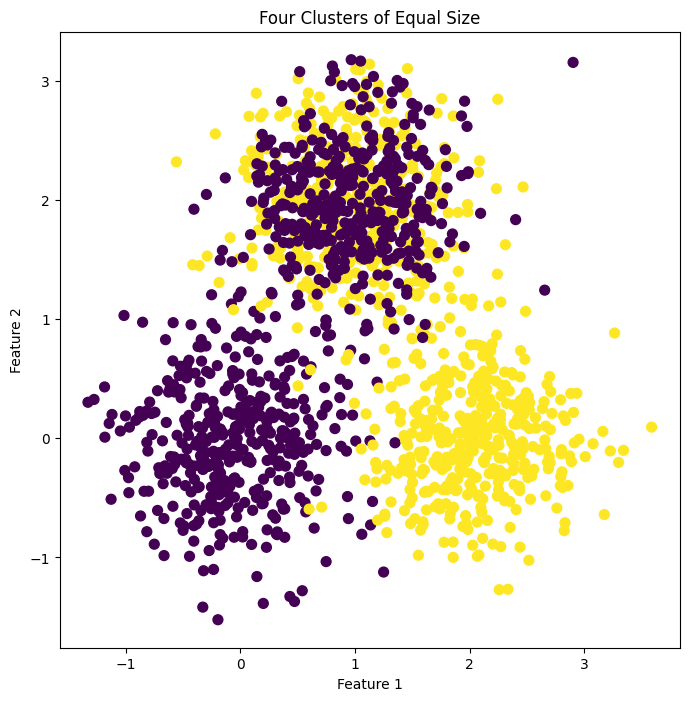

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)


In [7]:
from sklearn.model_selection import KFold
import torch
import torch.utils.data as data

train_data, test_data, val_data = generate_data("data2")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)





### Undersampling

In [8]:
import numpy as np
from collections import Counter

# --- This block generates the list of ratios for your experiment ---
def generate_ratios(train_data):
    # 1. Get original class counts from your train_dataset

    try:
        original_labels = np.array(train_data.targets).flatten()
    except AttributeError:
        original_labels = train_data[:, -1]

    original_counts = Counter(original_labels)
    num_pos_original = original_counts.get(1, 0)  
    num_neg_original = original_counts.get(0, 0)  
    print(f"Original class counts: {num_pos_original} positives, {num_neg_original} negatives")

    # The pivot point for your function's logic
    orig_sample_ratio = num_pos_original / num_neg_original 

    # 2. Define how many steps for each regime
    N_POINTS_PER_REGIME = 200  # You can change this

    # 3. Generate ratios for Regime 1 (from near 0 up to the pivot)
    # This will test scenarios from extreme negative-class dominance up to the original balance.
    print(f"Generating ratios for Regime 1 (target ratio < {orig_sample_ratio})...")
    ratios_regime1 = np.geomspace(
        start=2/(num_neg_original-1),                      # A small starting ratio (e.g., 1 positive for every 10 negatives)
        stop=orig_sample_ratio,         # Go up to the original ratio
        num=N_POINTS_PER_REGIME,
        endpoint=False                  # Exclude the pivot itself to avoid the 'else' block
    )

    # 4. Generate ratios for Regime 2 (from the pivot up to 3494)
    # This will test scenarios from the original balance up to extreme positive-class dominance.
    print(f"Generating ratios for Regime 2 (target ratio > {orig_sample_ratio})...")
    ratios_regime2 = np.geomspace(
        start=orig_sample_ratio, # Start just above the pivot
        stop=(num_pos_original-1)/2,                      # Your specified upper limit
        num=N_POINTS_PER_REGIME
    )

    # 5. Combine, sort, and create the final list for the loop
    #    We also add the original ratio to ensure we have a baseline run.
    all_ratios = sorted(list(np.concatenate([ratios_regime1, ratios_regime2, [orig_sample_ratio]])))

    print(f"\nGenerated {len(all_ratios)} unique sample ratios to test.")
    print("First few ratios:", np.round(all_ratios[:5], 3))
    print("Last few ratios:", np.round(all_ratios[-5:], 2))

    return all_ratios

In [9]:
import numpy as np
def undersample_dataset(train_dataset, sample_ratio):

    
    
    # Get the labels from the dataset (0 for normal, 1 for pneumonia)
    try:
        labels = np.array(train_dataset.targets).flatten()
    except AttributeError:
        labels = train_dataset[:, -1]

    # Find the indices for the positive (pneumonia) and negative (normal) classes
    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]
    num_orig_positive = len(positive_indices)
    num_orig_negative = len(negative_indices)

    orig_sample_ratio = num_orig_positive / num_orig_negative
    print(f"Original sample ratio (positive:negative): {orig_sample_ratio:.2f}")

    #based on sample ratio find the number of positive or negative samples
    if sample_ratio>orig_sample_ratio:
        neg_samples = int(num_orig_positive / sample_ratio)
        pos_samples = num_orig_positive
        sampled_negative_indices = np.random.choice(negative_indices, neg_samples, replace=False)
        final_indices = np.concatenate([sampled_negative_indices, positive_indices])
    elif sample_ratio<orig_sample_ratio:
        pos_samples = int(sample_ratio * num_orig_negative)
        neg_samples = num_orig_negative
        sampled_positive_indices = np.random.choice(positive_indices, pos_samples, replace=False)
        final_indices = np.concatenate([sampled_positive_indices, negative_indices])
    else:
        pos_samples = num_orig_positive
        neg_samples = num_orig_negative
        final_indices = np.concatenate([positive_indices, negative_indices])
        
    # Shuffle the final indices to mix positive and negative samples
    np.random.shuffle(final_indices)

    # Create a subset of the original dataset with the sampled indices
    return train_dataset[final_indices]

### Regular training

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
# Logistic Regression
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

#calculate ROC results
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
results_original_roc = {"fpr": fpr_roc, "tpr": tpr_roc, "thresholds": threshold_roc, "name": "Quadratic Discriminant Analysis", "auc": auc(fpr_roc, tpr_roc), "model": clf}

## Undersampling ROC curve

In [11]:


#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds 
list_folds_best_models = []  # List to store best models from all folds

list_weighted_clfs = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage

    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")
    X_train_fold = train_data[train_ids][:, :-1]
    y_train_fold = train_data[train_ids][:, -1]
    X_test_fold = train_data[val_ids][:, :-1]
    y_test_fold = train_data[val_ids][:, -1]
    all_ratios = generate_ratios(np.c_[X_train_fold, y_train_fold])  # Combine features and labels for ratio generation
    for i, sample_ratio in enumerate(all_ratios):
        print("="*60)
        print(f"--- STARTING STAGE {i+1} FOR SAMPLE RATIO: {sample_ratio} ---")
        print("="*60)

        undersampled_train_dataset = undersample_dataset(np.c_[X_train_fold, y_train_fold], sample_ratio)
        X_train_resampled = undersampled_train_dataset[:, :-1]  # All columns except the last one
        y_train_resampled = undersampled_train_dataset[:, -1]   # Last column is the target

        clf_weighted = QuadraticDiscriminantAnalysis(reg_param=0.001)
        clf_weighted.fit(X_train_resampled, y_train_resampled)

        res = get_fpr_tpr(clf_weighted, X_test_fold, y_test_fold, threshold=0.5)

        array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(y_test_fold, clf_weighted.predict_proba(X_test_fold)[:, 1])

        current_result = {
            "model": clf_weighted,
            "fpr": res["fpr"],
            "tpr": res["tpr"],
            "threshold": 0.5,
            "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},
        }
        list_weighted_clfs.append(current_result)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)

--- Starting Fold 1/4 ---
Original class counts: 378 positives, 372 negatives
Generating ratios for Regime 1 (target ratio < 1.0161290322580645)...
Generating ratios for Regime 2 (target ratio > 1.0161290322580645)...

Generated 401 unique sample ratios to test.
First few ratios: [0.005 0.006 0.006 0.006 0.006]
Last few ratios: [169.71 174.23 178.86 183.62 188.5 ]
--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.005390835579514825 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.0055339158378351905 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.005680793644795109 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.005831569792606157 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.0059863477486451055 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 6 FOR SAMPLE RATIO: 0.006145233726456505 ---
Origina

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discri

Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 37 FOR SAMPLE RATIO: 0.013842316829369566 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 38 FOR SAMPLE RATIO: 0.014209711130027652 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 39 FOR SAMPLE RATIO: 0.014586856585338523 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 40 FOR SAMPLE RATIO: 0.014974012004480472 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 41 FOR SAMPLE RATIO: 0.01537144306578659 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 42 FOR SAMPLE RATIO: 0.015779422499061665 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 43 FOR SAMPLE RATIO: 0.016198230272738035 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 44 FOR SAMPLE RATIO: 0.01662815378599881 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 45 FOR SAMPLE RATIO: 0.01706948

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 388 FOR SAMPLE RATIO: 134.00681028769034 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 389 FOR SAMPLE RATIO: 137.5706142743158 ---
Original sample ratio (positive:negative): 1.02


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 390 FOR SAMPLE RATIO: 141.2291947788499 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 391 FOR SAMPLE RATIO: 144.98507230701614 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 392 FOR SAMPLE RATIO: 148.84083439537315 ---
Original sample ratio (positive:negative): 1.02


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 393 FOR SAMPLE RATIO: 152.79913739394576 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 394 FOR SAMPLE RATIO: 156.86270829626352 ---
Original sample ratio (positive:negative): 1.02


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 395 FOR SAMPLE RATIO: 161.03434661806955 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 396 FOR SAMPLE RATIO: 165.31692632598921 ---
Original sample ratio (positive:negative): 1.02


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 397 FOR SAMPLE RATIO: 169.71339781749333 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 398 FOR SAMPLE RATIO: 174.22678995351467 ---
Original sample ratio (positive:negative): 1.02


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 399 FOR SAMPLE RATIO: 178.86021214512047 ---
Original sample ratio (positive:negative): 1.02
--- STARTING STAGE 400 FOR SAMPLE RATIO: 183.6168564956803 ---
Original sample ratio (positive:negative): 1.02


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 401 FOR SAMPLE RATIO: 188.5 ---
Original sample ratio (positive:negative): 1.02


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- Starting Fold 2/4 ---
Original class counts: 368 positives, 382 negatives
Generating ratios for Regime 1 (target ratio < 0.9633507853403142)...
Generating ratios for Regime 2 (target ratio > 0.9633507853403142)...

Generated 401 unique sample ratios to test.
First few ratios: [0.005 0.005 0.006 0.006 0.006]
Last few ratios: [165.12 169.54 174.07 178.72 183.5 ]
--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.005249343832020997 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.0053879482673012125 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.005530212434177244 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.0056762329647325185 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.0058261090425379925 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 6 FOR SAMPLE RATIO: 0.005979942470022021 ---
Origin

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discri

Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 35 FOR SAMPLE RATIO: 0.012732993696224725 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 36 FOR SAMPLE RATIO: 0.0130691975070565 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 37 FOR SAMPLE RATIO: 0.013414278492032439 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 38 FOR SAMPLE RATIO: 0.013768471045345121 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 39 FOR SAMPLE RATIO: 0.014132015750165362 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 40 FOR SAMPLE RATIO: 0.014505159542056901 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 41 FOR SAMPLE RATIO: 0.014888155876705873 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 42 FOR SAMPLE RATIO: 0.015281264902079083 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 43 FOR SAMPLE RATIO: 0.01568475

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 389 FOR SAMPLE RATIO: 133.70805747425953 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 390 FOR SAMPLE RATIO: 137.28216517928766 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 391 FOR SAMPLE RATIO: 140.95181122455082 ---
Original sample ratio (positive:negative): 0.96


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 392 FOR SAMPLE RATIO: 144.71954941514073 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 393 FOR SAMPLE RATIO: 148.5880018211031 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 394 FOR SAMPLE RATIO: 152.5598606022074 ---
Original sample ratio (positive:negative): 0.96


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 395 FOR SAMPLE RATIO: 156.63788988149267 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 396 FOR SAMPLE RATIO: 160.82492766889428 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 397 FOR SAMPLE RATIO: 165.12388783629214 ---
Original sample ratio (positive:negative): 0.96


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 398 FOR SAMPLE RATIO: 169.53776214535185 ---
Original sample ratio (positive:negative): 0.96
--- STARTING STAGE 399 FOR SAMPLE RATIO: 174.06962232957133 ---
Original sample ratio (positive:negative): 0.96


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 400 FOR SAMPLE RATIO: 178.72262223198356 ---
Original sample ratio (positive:negative): 0.96


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discri

--- STARTING STAGE 401 FOR SAMPLE RATIO: 183.5 ---
Original sample ratio (positive:negative): 0.96
--- Starting Fold 3/4 ---
Original class counts: 370 positives, 380 negatives
Generating ratios for Regime 1 (target ratio < 0.9736842105263158)...
Generating ratios for Regime 2 (target ratio > 0.9736842105263158)...

Generated 401 unique sample ratios to test.
First few ratios: [0.005 0.005 0.006 0.006 0.006]
Last few ratios: [166.04 170.48 175.03 179.7  184.5 ]
--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.005277044854881266 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.005416527125593203 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.005559696176383377 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.005706649455818374 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.005857486988214615 ---
Original sample ratio 

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 27 FOR SAMPLE RATIO: 0.010398587249511225 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 28 FOR SAMPLE RATIO: 0.010673441566964363 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 29 FOR SAMPLE RATIO: 0.010955560803584879 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 30 FOR SAMPLE RATIO: 0.01124513698491924 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 31 FOR SAMPLE RATIO: 0.011542367212112102 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 32 FOR SAMPLE RATIO: 0.011847453796063936 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 33 FOR SAMPLE RATIO: 0.012160604395134767 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 34 FOR SAMPLE RATIO: 0.01248203215648759 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 35 FOR SAMPLE RATIO: 0.012811955861167831 ---
Original sample ratio (positive:n

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 389 FOR SAMPLE RATIO: 134.47915418084114 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 390 FOR SAMPLE RATIO: 138.07024188897282 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 391 FOR SAMPLE RATIO: 141.75722483831174 ---
Original sample ratio (positive:negative): 0.97


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 392 FOR SAMPLE RATIO: 145.54266378427045 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 393 FOR SAMPLE RATIO: 149.4291878638435 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 394 FOR SAMPLE RATIO: 153.4194964216469 ---
Original sample ratio (positive:negative): 0.97


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 395 FOR SAMPLE RATIO: 157.51636088471938 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 396 FOR SAMPLE RATIO: 161.72262668738875 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 397 FOR SAMPLE RATIO: 166.0412152475376 ---
Original sample ratio (positive:negative): 0.97


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 398 FOR SAMPLE RATIO: 170.47512599564413 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 399 FOR SAMPLE RATIO: 175.02743845800475 ---
Original sample ratio (positive:negative): 0.97
--- STARTING STAGE 400 FOR SAMPLE RATIO: 179.70131439558773 ---
Original sample ratio (positive:negative): 0.97


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 401 FOR SAMPLE RATIO: 184.5 ---
Original sample ratio (positive:negative): 0.97
--- Starting Fold 4/4 ---
Original class counts: 384 positives, 366 negatives
Generating ratios for Regime 1 (target ratio < 1.0491803278688525)...
Generating ratios for Regime 2 (target ratio > 1.0491803278688525)...

Generated 401 unique sample ratios to test.
First few ratios: [0.005 0.006 0.006 0.006 0.006]
Last few ratios: [172.47 177.04 181.74 186.55 191.5 ]
--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.005479452054794521 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.005625326005366303 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.005775083411663704 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.005928827659029426 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.006086664885130373 ---
Original sample ratio 

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discri

Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 24 FOR SAMPLE RATIO: 0.010027210383926443 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 25 FOR SAMPLE RATIO: 0.010294154738451433 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 26 FOR SAMPLE RATIO: 0.010568205684509295 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 27 FOR SAMPLE RATIO: 0.010849552413751252 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 28 FOR SAMPLE RATIO: 0.01113838915448789 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 29 FOR SAMPLE RATIO: 0.011434915305775109 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 30 FOR SAMPLE RATIO: 0.011739335575069667 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 31 FOR SAMPLE RATIO: 0.01205186011954942 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 32 FOR SAMPLE RATIO: 0.01237270

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 389 FOR SAMPLE RATIO: 139.89682408789776 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 390 FOR SAMPLE RATIO: 143.60556353656733 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 391 FOR SAMPLE RATIO: 147.41262364682305 ---
Original sample ratio (positive:negative): 1.05


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 392 FOR SAMPLE RATIO: 151.32061095186245 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 393 FOR SAMPLE RATIO: 155.3322010854694 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 394 FOR SAMPLE RATIO: 159.45014061390643 ---
Original sample ratio (positive:negative): 1.05


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 395 FOR SAMPLE RATIO: 163.6772489163732 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 396 FOR SAMPLE RATIO: 168.01642011531666 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 397 FOR SAMPLE RATIO: 172.47062505791354 ---
Original sample ratio (positive:negative): 1.05


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 398 FOR SAMPLE RATIO: 177.04291335008443 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 399 FOR SAMPLE RATIO: 181.7364154444299 ---
Original sample ratio (positive:negative): 1.05
--- STARTING STAGE 400 FOR SAMPLE RATIO: 186.55434478351967 ---
Original sample ratio (positive:negative): 1.05


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- STARTING STAGE 401 FOR SAMPLE RATIO: 191.5 ---
Original sample ratio (positive:negative): 1.05


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


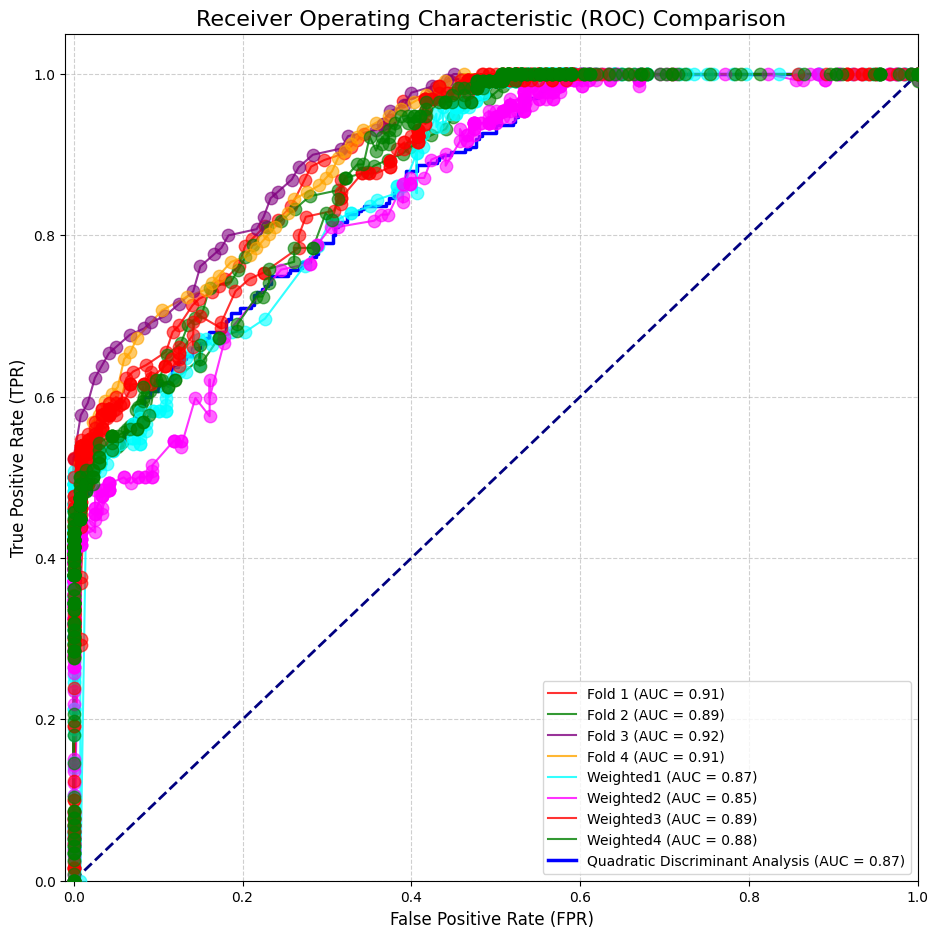

In [12]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc
)

### Ensemble prediction using voting

In [13]:


# --- Loop through all the FPR values to generate the ensemble ROC curve ---

ensemble_results_soft = []
ensemble_results_hard = []

print("\n--- Generating Ensemble ROC Curve by iterating through FPR values ---")
# We iterate from a low to high target_fpr to trace the curve
for target_fpr in np.linspace(0.0, 1.0, 50): 
    # 1. Assign the function's output to a single variable first.
    result_tuple = predict_ensemble_and_evaluate(
        list_folds_best_models=list_folds_best_models,
        test_loader=test_loader,
        target_fpr=target_fpr
    )
    
    if result_tuple is not None:
        
        for voting_method, metrics in result_tuple.items():
            # Create a dictionary for each point and append it to the list
            if voting_method == 'soft_voting':
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_soft.append(point_dict)
            else:
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_hard.append(point_dict)
            
        
# Ensure the curve starts at (0, 0)
    if not ensemble_results_soft or ensemble_results_soft[0]['fpr'] > 0.0:
        ensemble_results_soft.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_soft[-1]['fpr'] < 1.0 or ensemble_results_soft[-1]['tpr'] < 1.0:
        ensemble_results_soft.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    if not ensemble_results_hard or ensemble_results_hard[0]['fpr'] > 0.0:
        ensemble_results_hard.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_hard[-1]['fpr'] < 1.0 or ensemble_results_hard[-1]['tpr'] < 1.0:
        ensemble_results_hard.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })







--- Generating Ensemble ROC Curve by iterating through FPR values ---
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0000
Soft Voting -> Achieved [TPR: 0.0000, FPR: 0.0000]
Hard Voting -> Resulted in [TPR: 0.0000, FPR: 0.0000]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0204
Soft Voting -> Achieved [TPR: 0.4833, FPR: 0.0233]
Hard Voting -> Resulted in [TPR: 0.4867, FPR: 0.0300]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0408
Soft Voting -> Achieved [TPR: 0.5167, FPR: 0.0433]
Hard Voting -> Resulted in [TPR: 0.5267, FPR: 0.0400]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0612
Soft Voting -> Achieved [TPR: 


--- Plotting all ROC curves for comparison ---


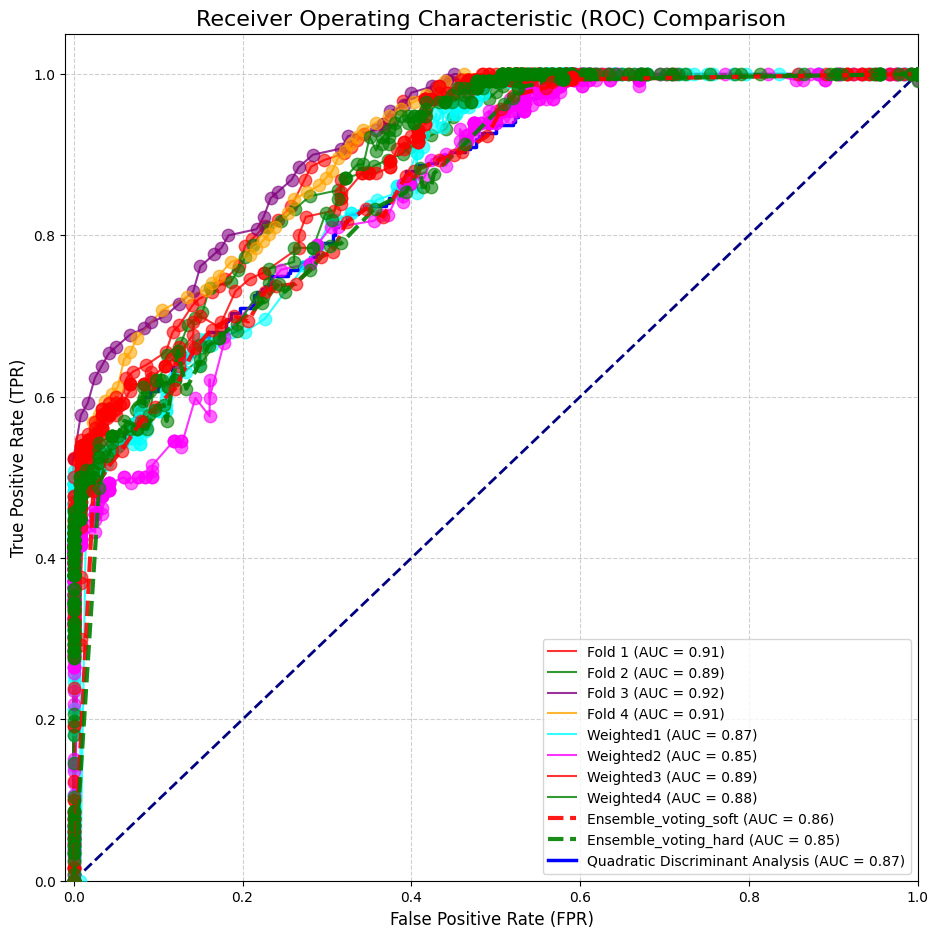

In [14]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(ensemble_results_soft)
results_lists.append(ensemble_results_hard)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Ensemble_voting_soft", "Ensemble_voting_hard"],
    results_original_roc=results_original_roc
)